In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import json
import os

from tqdm import tqdm

from wordcloud import WordCloud

In [ ]:
import nltk
from nltk.corpus import stopwords

import spacy
import gensim

In [33]:
import torch
from sentence_transformers import SentenceTransformer, util

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [16]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available.
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU


# Load Model

In [17]:
checkpoint = "sentence-transformers/all-MiniLM-L6-v2"

embedder = SentenceTransformer(checkpoint).to('cuda')

# Load Data

In [3]:
with open("temp/meta-data.json", "r") as file:
    data = json.load(file)

print(len(data))

1511


In [4]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         1511 non-null   int64 
 1   review_time       1511 non-null   object
 2   like              1511 non-null   int64 
 3   review            1511 non-null   object
 4   review_processed  1511 non-null   object
 5   aspect_sentiment  1511 non-null   object
dtypes: int64(2), object(4)
memory usage: 82.6+ KB
None


,review_id,review_time,like,review,review_processed,aspect_sentiment
0,0,2024-11-28,0,The cars design is like it came from a cartoon.,The cars design is like it came from a cartoon.,"[{'term': 'cars design', 'class': 'negative', ..."
1,2,2024-11-27,0,Tankz u for being so honest.\nMuch love and re...,Tankz u for being so honest.\nMuch love and re...,"[{'term': 'much love', 'class': 'positive', 'p..."
2,3,2024-11-26,0,Amazing review your really good at this love w...,Amazing review your really good at this love w...,"[{'term': 'well', 'class': 'positive', 'probab..."
3,5,2024-11-25,0,"Honestly, the Cybertruck might be the first ca...",The Cybertruck might be the first car I've eve...,"[{'term': 'first car', 'class': 'negative', 'p..."
4,6,2024-11-25,0,I will be buying one anytime soon add expensiv...,I will be buying one anytime soon. It's a very...,"[{'term': 'stuff', 'class': 'positive', 'proba..."


In [5]:
aspects = {}
text = ""
for items in df['aspect_sentiment'].values:
    for item in items:
        term = item.get('term')
        text = text + term + " " 
        if term not in aspects.keys():
            aspects[term] = 1
        else:
            aspects[term] = aspects[term] + 1
print(len(aspects))

3120


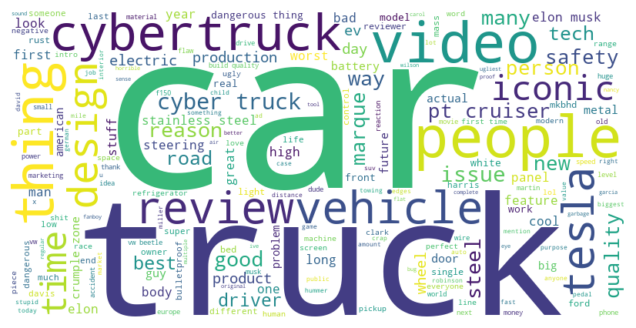

In [9]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
with open('temp/aspects.json', 'w', encoding='utf-8') as f:
    json.dump(list(aspects.keys()), f, indent=4)


In [20]:
with open('temp/aspects.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
print(len(data))
print(data[:5])

3120
['cars design', 'much love', 'tankz u', 'well', 'love']


# Clustering

In [21]:
embeddings = embedder.encode(data, convert_to_tensor=True, device='cuda').cpu().numpy()

# Normalize the embedding to unit length
embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

print(embeddings.shape)

c:\Users\Baha Tegar\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


(3120, 384)


OPTIMUM NUMBER OF CLUSTERS: 9


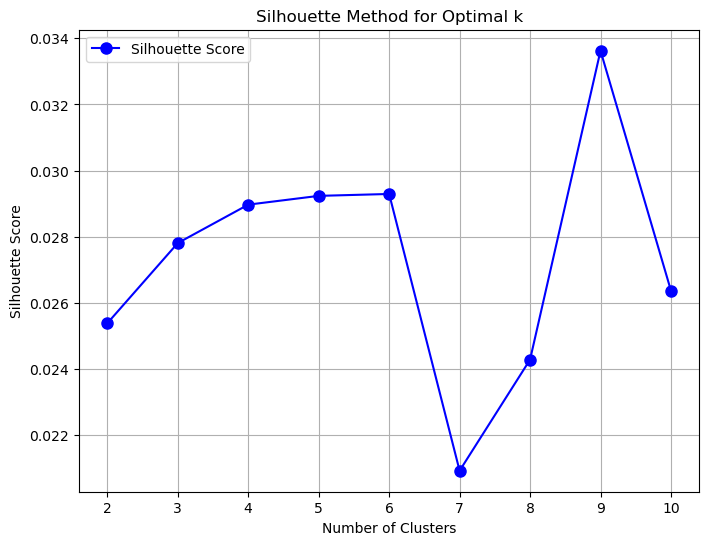

In [35]:
def find_silhouette_score(data, max_k=10):
    silhouette_scores = []
    K = range(2, max_k + 1)  # Silhouette is undefined for k=1

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    # Get Optimum Number of Clusters    
    n_opt = K[np.argmax(silhouette_scores)]
    print(f"OPTIMUM NUMBER OF CLUSTERS: {n_opt}")
    # Plot the Silhouette Method
    plt.figure(figsize=(8, 6))
    plt.plot(K, silhouette_scores, 'bo-', markersize=8, label='Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.legend()
    plt.grid()
    plt.show()

    return n_opt

n_clusters = find_silhouette_score(embeddings, max_k=10)

c:\Users\Baha Tegar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


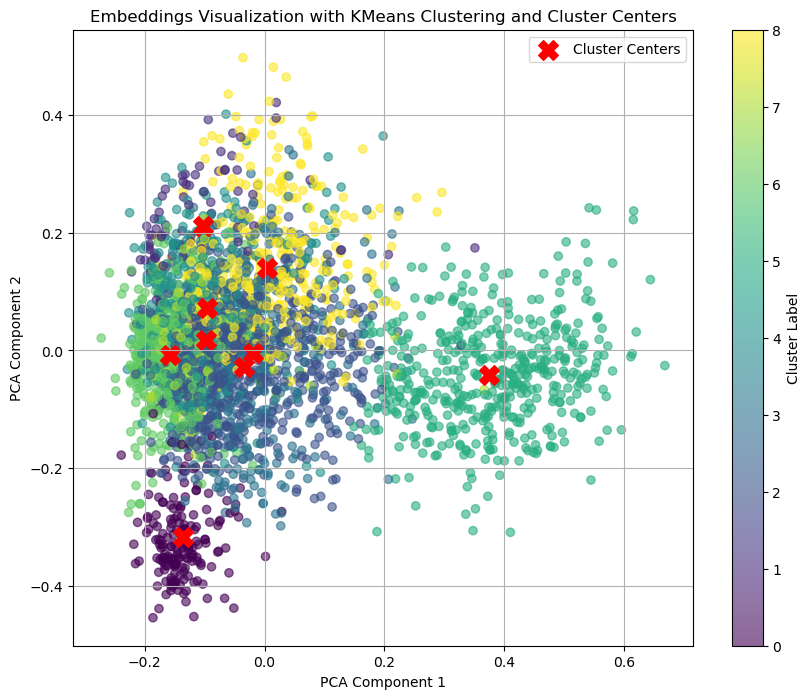

In [36]:
# Clustering with KMeans
# n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Get the cluster centers and reduce their dimensions
cluster_centers = kmeans.cluster_centers_
reduced_centers = pca.transform(cluster_centers)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)

# Adding labels for embeddings
# for i, label in enumerate(cluster_labels):
#     plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

# Plotting the cluster centers
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('Embeddings Visualization with KMeans Clustering and Cluster Centers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.grid()
plt.show()


In [38]:
# Calculate distance to cluster centers
distances = np.linalg.norm(embeddings - cluster_centers[cluster_labels], axis=1)

# Create DataFrame
df = pd.DataFrame({
    'word': data,
    'cluster_label': cluster_labels,
    'distance_to_center': distances
})

# Sort DataFrame by cluster and distance to center
df = df.sort_values(by=['cluster_label', 'distance_to_center']).reset_index(drop=True)

# Display the sorted DataFrame
print(df.head())

             word  cluster_label  distance_to_center
0    lewis sandra              0            0.711472
1     davis scott              0            0.715286
2     garcia paul              0            0.722116
3  davis patricia              0            0.726064
4    davis sandra              0            0.726363


In [48]:
mapper = {}
for label in np.unique(cluster_labels):
  temp = df[df['cluster_label'] == label]
  print(f"=============== LABEL: {label} ==================")
  print(f"TOTAL: {temp.shape[0]}")
  print(temp.iloc[:20])
  mapper[str(label)] = list(temp['word'].values)

=============== LABEL: 0 ==================
TOTAL: 179
                 word  cluster_label  distance_to_center
0        lewis sandra              0            0.711472
1         davis scott              0            0.715286
2         garcia paul              0            0.722116
3      davis patricia              0            0.726064
4        davis sandra              0            0.726363
5        carol garcia              0            0.726896
6         davis nancy              0            0.731351
7        martin carol              0            0.731491
8     robinson sandra              0            0.733809
9       johnson carol              0            0.734693
10       martin nancy              0            0.735775
11       laura martin              0            0.735788
12     gonzalez carol              0            0.741522
13    walker patricia              0            0.743287
14       davis daniel              0            0.748513
15        nancy davis            

In [49]:
print(len(mapper))

9


In [50]:
with open('temp/topic-classification.json', 'w', encoding='utf-8') as f:
    json.dump(mapper, f, indent=4)

In [51]:
torch.cuda.reset_peak_memory_stats()  # Reset peak stats for debugging
torch.cuda.empty_cache()  # Clear cache
